# Chat Fine-tuning

Quantized Low-Rank Adapter Model Fine-tuning

---

Built by Trelis. Find us on [HuggingFace](https://huggingface.co/Trelis).

This script is commercially licensed and available for purchase per seat/user. [Request access here](https://buy.stripe.com/5kAaFq4pLbe3bQYcNf).

You can also purchase access to the full GitHub Repo, including:
1. Embedding Notebook
2. Fine-tuning Notebook Supervised Learning + Data-prep
3. Fine-tuning Notebook Unsupervised Learning + Data-prep
4. Dataset Preparation
5. Quantization Notebooks (GGUF and AWQ)

[Request access here](https://buy.stripe.com/cN27tef4p2Hx2go4gD). Access will be granted within 24 hours of purchase.


In [1]:
# Required when training models/data that are gated on HuggingFace, and required for pushing models to HuggingFace
!pip install -q -U huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

In [2]:
!pip install wandb -q -U
import wandb
wandb.login()

wandb: Currently logged in as: ronankmcgovern (trelis). Use `wandb login --relogin` to force relogin


True

In [3]:
cache_dir=''

### Connect Google Drive

Optional but saves time by caching the model and allows for training data to be saved on Drive.

In [2]:
# # https://stackoverflow.com/questions/56081324/why-are-google-colab-shell-commands-not-working
# import locale
# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# import os
# cache_dir = "/content/drive/My Drive/huggingface_cache"
# os.makedirs(cache_dir, exist_ok=True) # Ensure the directory exists

# Installation

In [4]:
# stable versions

!python -m pip install --upgrade pip
!pip install -U -q transformers
!pip install -q -U bitsandbytes
!pip install -q -U peft
!pip install -q -U accelerate
!pip install -q datasets
!pip install -q -U scipy
!pip install -q -U trl
!pip install -U flash-attn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1


In [4]:
!transformers-cli env


Copy-and-paste the text below in your GitHub issue and FILL OUT the two last points.

- `transformers` version: 4.36.2
- Platform: Linux-5.4.0-155-generic-x86_64-with-glibc2.35
- Python version: 3.10.12
- Huggingface_hub version: 0.20.1
- Safetensors version: 0.4.1
- Accelerate version: 0.25.0
- Accelerate config: 	not found
- PyTorch version (GPU?): 2.1.0+cu118 (True)
- Tensorflow version (GPU?): not installed (NA)
- Flax version (CPU?/GPU?/TPU?): not installed (NA)
- Jax version: not installed
- JaxLib version: not installed
- Using GPU in script?: <fill in>
- Using distributed or parallel set-up in script?: <fill in>



# Load the Model

In [5]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoConfig
import torch

# using a base model here for unsupervised trial.
# model_id = "PY007/TinyLlama-1.1B-intermediate-step-715k-1.5T"
# model_id = "meta-llama/Llama-2-7b-hf"
# model_id = "meta-llama/Llama-2-7b-chat-hf"
# model_id = "meta-llama/Llama-2-13b-chat-hf"
# model_id  = "tiiuae/falcon-40b-instruct"
# model_id  = "tiiuae/falcon-7b"
# model_id  = "tiiuae/falcon-7b-instruct"
# model_id  = "tiiuae/falcon-180B"
# model_id  = "tiiuae/falcon-40B"
# model_id = "Trelis/TinyLlama-1.1B-chat-SFT"
model_id = "deepseek-ai/deepseek-coder-1.3b-base"
# model_id = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# config = AutoConfig.from_pretrained(model_id)
# config.max_position_embeddings = 4096 # (input + output) tokens can now be up to 4096

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    # config=config,
    # quantization_config=bnb_config,
    # rope_scaling={"type": "linear", "factor": 2.0},
    device_map='auto',
    # trust_remote_code=False,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2", # works with Llama models and reduces memory reqs
    cache_dir=cache_dir)

In [6]:
## Required for Yi models
# !pip install sentencepiece -q -U

In [7]:
for n, p in model.named_parameters():
    if p.device.type == "meta":
        print(f"{n} is on meta!")

In [8]:
print(model.config.max_position_embeddings)
print(model.config.eos_token_id)

16384
32014


### Prepare for LoRA fine-tuning

In [9]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable() #Comment this in to save on VRAM
# model = prepare_model_for_kbit_training(model)

In [10]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model and lists which parameters are trainable.
    """
    trainable_params = 0
    non_trainable_params = 0
    all_params = 0

    print("Trainable Parameters:")
    for name, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
            print(f"  {name}")
        else:
            non_trainable_params += param.numel()

    print("\nNon-Trainable Parameters:")
    for name, param in model.named_parameters():
        if not param.requires_grad:
            print(f"  {name}")

    print(
        f"\nSummary:\n  Trainable params: {trainable_params}\n  Non-Trainable params: {non_trainable_params}\n  All params: {all_params}\n  Trainable%: {100 * trainable_params / all_params}"
    )

In [11]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32256, 2048)
    (layers): ModuleList(
      (0-23): 24 x LlamaDecoderLayer(
        (self_attn): LlamaFlashAttention2(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaLinearScalingRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5504, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5504, bias=False)
          (down_proj): Linear(in_features=5504, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )


In [12]:
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig( #matching the Llama recipe
    r=8,
    lora_alpha=32,
    target_modules=[
              "self_attn.q_proj",
              "self_attn.k_proj",
              "self_attn.v_proj",
              "self_attn.o_proj",
              # "self_attn.rotary_emb.inv_freq",
              "mlp.gate_proj",
              "mlp.up_proj",
              "mlp.down_proj",
              # "input_layernorm.weight",
              # "post_attention_layernorm.weight",
              # "model.norm.weight",
              # "lm_head.weight",
                # "dense_h_to_4h", #for falcon
                # "dense_4h_to_h", #for falcon
                # "query_key_value", #for falcon
                # "dense" #for falcon
              ],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

In [13]:
model = get_peft_model(model, peft_config) #move to a peft model

In [14]:
# print_trainable_parameters(model)

# Set up Tokenizer and Padding

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_id,use_fast=True,trust_remote_code=True)
print(tokenizer)
print(tokenizer.vocab_size)

tokenizer_config.json:   0%|          | 0.00/793 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


LlamaTokenizerFast(name_or_path='deepseek-ai/deepseek-coder-1.3b-base', vocab_size=32000, model_max_length=16384, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<｜begin▁of▁sentence｜>', 'eos_token': '<｜end▁of▁sentence｜>', 'pad_token': '<｜end▁of▁sentence｜>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	32000: AddedToken("õ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	32001: AddedToken("÷", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	32002: AddedToken("Á", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	32003: AddedToken("ý", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	32004: AddedToken("À", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	32005: AddedToken("ÿ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	32006: AddedT

In [15]:
print(tokenizer.bos_token)
print(tokenizer.eos_token)

<｜begin▁of▁sentence｜>
<｜end▁of▁sentence｜>


In [17]:
# OPTIONALLY SET THE CHAT TEMPLATE MANUALLY.
tokenizer.chat_template = "{% if not add_generation_prompt is defined %}\n{% set add_generation_prompt = false %}\n{% endif %}\n{%- set ns = namespace(found=false) -%}\n{%- for message in messages -%}\n    {%- if message['role'] == 'system' -%}\n        {%- set ns.found = true -%}\n    {%- endif -%}\n{%- endfor -%}\n{{bos_token}}{%- if not ns.found -%}\n{{'\\n'}}\n{%- endif %}\n{%- for message in messages %}\n    {%- if message['role'] == 'system' %}\n{{ message['content'] }}\n    {%- else %}\n        {%- if message['role'] == 'user' %}\n{{'### Instruction:\\n' + message['content'] + '\\n'}}\n        {%- else %}\n{{'### Response:\\n' + message['content'] + eos_token}}\n        {%- endif %}\n    {%- endif %}\n{%- endfor %}\n{% if add_generation_prompt %}\n{{'### Response:'}}\n{% endif %}"

#Test the chat template
messages=[
    { 'role': 'user', 'content': "write a quick sort algorithm in python."},
    { 'role': 'assistant', 'content': "here you are."},
    { 'role': 'user', 'content': "great."},
]

inputs = tokenizer.apply_chat_template(messages, tokenize=False)
print(inputs)

<｜begin▁of▁sentence｜>
### Instruction:
write a quick sort algorithm in python.
### Response:
here you are.<｜end▁of▁sentence｜>### Instruction:
great.



In [18]:
## OPTION A - set the pad token to <unk> if <unk> is in the tokenizer OR set it to the EOS token.
if '<pad>' in tokenizer.get_vocab():
    print('<pad> token is in the tokenizer. Using <pad> for pad')
    # Set the pad token
    tokenizer.pad_token = '<pad>'
elif '<unk>' in tokenizer.get_vocab():
    print('<unk> token is in the tokenizer. Using unk for pad')
    # Set the pad token
    tokenizer.pad_token = '<unk>'
else:
    print(f'Using EOS token, {tokenizer.eos_token}, for padding')
    tokenizer.pad_token = tokenizer.eos_token

# OPTION B - create a pad token
# Check if the pad token is already in the tokenizer vocabulary
# if '<pad>' not in tokenizer.get_vocab():
#     print('pad token not in the tokenizer, adding a <pad> token')

#     # Add the pad token
#     tokenizer.add_tokens(['<pad>'])
#     # Set the pad token
#     tokenizer.pad_token = '<pad>'
#     # Resize token embeddings
#     model.resize_token_embeddings(tokenizer.vocab_size)

<pad> token is in the tokenizer. Using <pad> for pad


In [19]:
# Update pad token id in model and its config
model.pad_token_id = tokenizer.pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# Check if they are equal
assert model.pad_token_id == tokenizer.pad_token_id, "The model's pad token ID does not match the tokenizer's pad token ID!"

# Print the pad token ids
print('Tokenizer pad token ID:', tokenizer.pad_token_id)
print('Model pad token ID:', model.pad_token_id)
print('Model config pad token ID:', model.config.pad_token_id)
print('Number of tokens now in tokenizer:', tokenizer.vocab_size)

Tokenizer pad token ID: 32018
Model pad token ID: 32018
Model config pad token ID: 32018
Number of tokens now in tokenizer: 32000


In [20]:
print("Special tokens map:", tokenizer.special_tokens_map)
# print("All special tokens:", tokenizer.all_special_tokens)

Special tokens map: {'bos_token': '<｜begin▁of▁sentence｜>', 'eos_token': '<｜end▁of▁sentence｜>', 'pad_token': '<pad>'}


In [21]:
# print(model)

In [22]:
# List to hold the names of the trainable parameters
# trainable_params_names = ["word_embeddings","input_layernorm", "ln_f"] #for Falcon
# trainable_params_names = ["embed_tokens", "input_layernorm", "post_attention_layernorm"] #for Llama 2
trainable_params_names = ["embed", "norm"] #for DeepSeek Coder

# Set modules to be trainable
for n, p in model.named_parameters():
    if any(k in n for k in trainable_params_names):
        p.requires_grad_(True)
    # else:
    #     p.requires_grad_(False)  # Optional: Set the rest to be not trainable

# Make a dictionary of trainable parameters
trainable_params = {n: p for n, p in model.named_parameters() if p.requires_grad}

# Convert trainable_params to state_dict format
trainable_params_state_dict = {n: p.data for n, p in trainable_params.items()}

In [23]:
# print_trainable_parameters(model)

In [24]:
#Switch to left padding
tokenizer.padding_side='left'

In [25]:
print(tokenizer)

LlamaTokenizerFast(name_or_path='deepseek-ai/deepseek-coder-1.3b-base', vocab_size=32000, model_max_length=16384, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<｜begin▁of▁sentence｜>', 'eos_token': '<｜end▁of▁sentence｜>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	32000: AddedToken("õ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	32001: AddedToken("÷", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	32002: AddedToken("Á", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	32003: AddedToken("ý", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	32004: AddedToken("À", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	32005: AddedToken("ÿ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	32006: AddedToken("ø", rstr

# Set up Evaluation

In [31]:
from transformers import TextStreamer
from peft import PeftModel
import torch
import gc  # import Python's garbage collection module

# Define a stream
def stream(user_prompt, model_type, tokenizer, checkpoint=''):

    if model_type == 'base':
        eval_model = model
    elif model_type == 'fine-tuned':
        eval_model = PeftModel.from_pretrained(model, checkpoint)  # Assuming PeftModel is the intended class
        eval_model = eval_model.to("cuda")

        for n, p in eval_model.named_parameters():
            if p.device.type == "cpu":
                print(f"{n} is on cpu!")
        
    else:
        print('You must set the model_type to base or fine-tuned')
        exit()  # or raise an exception

    # print(f'Proceeding to inference with peft adapters from {checkpoint}')

    eval_model.config.use_cache = True

    messages=[
        { 'role': 'user', 'content': f"{user_prompt.strip()}"},
    ]
    
    inputs = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    inputs = tokenizer([inputs], return_tensors="pt", add_special_tokens=False).to("cuda")

    if "token_type_ids" in inputs:
        del inputs["token_type_ids"]
    
    streamer = TextStreamer(tokenizer)

    print(f'eval_model is on: {next(eval_model.parameters()).device}')  # Debug line
    print(f'input_ids are on: {inputs["input_ids"].device}')  # Debug line

    # Despite returning the usual output, the streamer will also print the generated text to stdout.
    # _ = eval_model.generate(**inputs, streamer=streamer)
    _ = eval_model.generate(**inputs, streamer=streamer, max_new_tokens=100, pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id)
    
    # Clear GPU cache and run garbage collection
    torch.cuda.empty_cache()  # Clear GPU cache
    gc.collect()  # Run garbage collection


def evaluation(model_type, tokenizer, checkpoint=''):
    questions = [
        "What planets are in our solar system?",
        "What are the first five numbers in the Fibonacci series?",
        "Generate a python code snippet to add two numbers."
    ]

    #Optionally provide some correct answers for comparison. This is for manual evaluation. Recommended!
    answers = [
        "",
        "",
        ""
    ]

    for question, answer in zip(questions, answers):
        stream(question, model_type, tokenizer, checkpoint)
        # print("Correct Answer:", answer)
        print('\n\n')

In [32]:
# print(model.config)

In [33]:
print(model.generation_config)

GenerationConfig {
  "bos_token_id": 32013,
  "eos_token_id": 32014,
  "pad_token_id": 32018
}



In [34]:
evaluation("base", tokenizer)

eval_model is on: cuda:0
input_ids are on: cuda:0
<｜begin▁of▁sentence｜>
### Instruction:
What planets are in our solar system?
### Response:
- Mercury
- Venus
- Earth
- Mars
- Jupiter
- Saturn
- Uranus
- Neptune

### Instruction:What is the distance between Earth and the Sun?
### Response:
- 149,597,870 km

### Instruction:What is the distance between Earth and the Moon?
### Response:
- 384,400 km

###



eval_model is on: cuda:0
input_ids are on: cuda:0
<｜begin▁of▁sentence｜>
### Instruction:
What are the first five numbers in the Fibonacci series?
### Response:
```
1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 1771



eval_model is on: cuda:0
input_ids are on: cuda:0
<｜begin▁of▁sentence｜>
### Instruction:
Generate a python code snippet to add two numbers.
### Response:
```python
a = 10
b = 20
c = a + b
print(c)
```

### Instruction:Generate a python code snippet to add two numbers.
### Response:
```python
a = 10
b = 20
c = a + b
print(c)

# Load the Dataset

In [35]:
## There is truncation, so don't unintentionally use datasets that are larger (unless you update the truncation parameter)!

from datasets import load_dataset

# dataset="Trelis/openassistant-guanaco-EOS"
# dataset="Trelis/openassistant-falcon"
# dataset="timdettmers/openassistant-guanaco"
# dataset="Trelis/openassistant-llama-style"
# dataset="Trelis/openassistant-yi"
dataset="Trelis/openassistant-deepseek-coder"

data = load_dataset(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [36]:
# Print first row of 'train' and 'test'
print("First row of train:", data['train'][1])
# print("First row of test:", data['test'][0])

First row of train: {'text': '\n### Instruction:\n¿CUales son las etapas del desarrollo y en qué consisten según Piaget?\n### Response:\nJean Piaget fue un psicólogo suizo que propuso una teoría sobre el desarrollo cognitivo humano que consta de cuatro etapas:\n\nEtapa sensoriomotora (0-2 años): Durante esta etapa, el niño aprende a través de sus sentidos y movimientos. Descubre que sus acciones pueden tener un impacto en el entorno y comienza a formarse una idea básica de objetividad y continuidad.\n\nEtapa preoperatoria (2-7 años): En esta etapa, el niño comienza a desarrollar un pensamiento simbólico y a comprender que las cosas pueden representar a otras cosas. También comienzan a desarrollar un pensamiento lógico y a comprender conceptos como la causa y el efecto.\n\nEtapa de operaciones concretas (7-12 años): Durante esta etapa, el niño desarrolla un pensamiento lógico y comprende las relaciones causales. Empiezan a comprender que las cosas pueden tener múltiples perspectivas y q

In [37]:
# Extract text from the first row of 'test' in data
text = data['train'][0]['text']

# Tokenize the text
tokens = tokenizer.encode(text, add_special_tokens=True)

# Decode back to text
decoded_text = tokenizer.decode(tokens)

# Print tokens and decoded text
print("Token IDs:", tokens)
print("Decoded Text:", decoded_text)

Token IDs: [32013, 185, 13518, 3649, 3475, 25, 185, 5895, 340, 3697, 245, 2567, 14232, 782, 254, 299, 31367, 280, 254, 1632, 440, 2311, 424, 1980, 88, 1, 279, 4924, 959, 30, 6456, 931, 6989, 4512, 276, 3956, 19825, 1980, 476, 279, 254, 20211, 2882, 285, 258, 547, 7688, 3965, 13, 185, 13518, 21289, 25, 185, 1, 8704, 424, 1980, 88, 1, 13467, 276, 245, 2882, 4315, 1064, 741, 317, 885, 629, 25041, 327, 245, 2580, 1205, 409, 2408, 13, 680, 4924, 959, 11, 437, 1632, 317, 7288, 7688, 279, 254, 8696, 2882, 11, 1064, 245, 19825, 1980, 88, 20731, 638, 4474, 1813, 851, 254, 26533, 285, 2681, 4469, 280, 699, 8907, 13, 428, 6944, 280, 245, 19825, 1980, 88, 482, 1228, 279, 3916, 26533, 285, 8489, 14658, 8979, 327, 10713, 11, 372, 254, 20731, 638, 1576, 23075, 488, 276, 4675, 26533, 409, 2764, 2007, 2681, 4469, 13, 185, 185, 29233, 3965, 638, 10738, 3956, 19825, 1980, 476, 279, 19656, 1109, 372, 11437, 285, 4299, 3411, 11, 1064, 245, 1853, 2307, 5201, 2675, 245, 4474, 10265, 280, 254, 2882, 334, 33, 

# Train!

## Set up and run Training (with saving of data logs to Drive)
Using the TRL trainer is recommended.

### TRL Trainer


In [39]:
model_name = model_id.split("/")[-1]
dataset_name = dataset.split("/")[-1]

epochs=1
context_length = 512*8
grad_accum=8
batch_size=4
fine_tune_tag='fine-tuned-model'
save_dir = f'./results/{model_name}_{dataset_name}_{epochs}_epochs_{context_length}_length-{fine_tune_tag}'
print(save_dir)

./results/deepseek-coder-1.3b-base_openassistant-deepseek-coder_1_epochs_4096_length-chat


In [40]:
import transformers
import os

# Custom callback to log metrics
class LoggingCallback(transformers.TrainerCallback):
    def __init__(self, log_file_path):
        self.log_file_path = log_file_path
        self.save_dir = save_dir

    def on_log(self, args, state, control, model=None, logs=None, **kwargs):
        with open(self.log_file_path, 'a') as f:
            if 'loss' in logs:
                f.write(f"Step: {state.global_step}, Training Loss: {logs['loss']}\n")
            if 'eval_loss' in logs:
                f.write(f"Step: {state.global_step}, Eval Loss: {logs['eval_loss']}\n")
            f.flush()  # Force flush the buffered data to file

        # Check if the current step is a checkpoint step
        if state.global_step % int(args.save_steps) == 0:
            # Check if the last checkpoint path exists
            if state.best_model_checkpoint:
                checkpoint_dir = state.best_model_checkpoint
            else:
                # If not, construct the checkpoint directory path manually
                checkpoint_dir = os.path.join(args.output_dir, f"checkpoint-{state.global_step}")
    
            # Ensure the checkpoint directory exists
            os.makedirs(checkpoint_dir, exist_ok=True)
    
            # Save trainable params in the checkpoint directory
            current_trainable_params = {n: p for n, p in model.named_parameters() if p.requires_grad}
            current_trainable_params_state_dict = {n: p.data for n, p in current_trainable_params.items()}
            file_path = os.path.join(checkpoint_dir, "trainable_params.bin")
            torch.save(current_trainable_params_state_dict, file_path)

# Log file path
log_file_path = os.path.join(cache_dir, "training_logs.txt")

# Create an instance of the custom callback
logging_callback = LoggingCallback(log_file_path)

In [41]:
from transformers import Trainer
from trl import SFTTrainer

trainer = SFTTrainer(
    # peft_config=peft_config, #comment out if passing a peft model directly as 'model'
    dataset_text_field="text",
    max_seq_length=context_length,
    tokenizer=tokenizer,
    model=model,
    train_dataset=data["train"],
    eval_dataset=data["test"],
    args=transformers.TrainingArguments(
        # max_steps=100, # comment this out after the first time you run. This is for testing!
        save_steps=75, ### MAKE SURE TO CHECK THIS VALUE IS GOOD FOR YOUR RUN!
        logging_steps=1,
        num_train_epochs=epochs,
        output_dir=save_dir,
        evaluation_strategy="steps",
        do_eval=True,
        eval_steps=0.25,
        per_device_eval_batch_size=batch_size,
        per_device_train_batch_size=batch_size,
        gradient_accumulation_steps=grad_accum,
        log_level="debug",
        # optim="paged_adamw_8bit",
        optim="adamw_torch",
        learning_rate=2.5e-5,
        # fp16=True,
        bf16=True, #use this for doing a full fine-tune without quantization, and with extra non-LoRA params enabled
        max_grad_norm=0.3,
        warmup_ratio=0.03,
        lr_scheduler_type="constant",
        hub_private_repo=True
    ),
    callbacks=[logging_callback],  # Add custom callback here
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Map:   0%|          | 0/9846 [00:00<?, ? examples/s]

Map:   0%|          | 0/518 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:282: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
max_steps is given, it will override any value given in num_train_epochs
Using auto half precision backend
Currently training with a batch size of: 4
***** Running training *****
  Num examples = 9,846
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 8
  Total optimization steps = 100
  Number of trainable parameters = 73,656

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.626400,1.706995
50,1.756100,1.630634
75,1.630400,1.611088
100,1.523300,1.596619


***** Running Evaluation *****
  Num examples = 518
  Batch size = 4
***** Running Evaluation *****
  Num examples = 518
  Batch size = 4
***** Running Evaluation *****
  Num examples = 518
  Batch size = 4
Checkpoint destination directory ./results/deepseek-coder-1.3b-base_openassistant-deepseek-coder_1_epochs_4096_length-chat/checkpoint-75 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Saving model checkpoint to ./results/deepseek-coder-1.3b-base_openassistant-deepseek-coder_1_epochs_4096_length-chat/checkpoint-75
tokenizer config file saved in ./results/deepseek-coder-1.3b-base_openassistant-deepseek-coder_1_epochs_4096_length-chat/checkpoint-75/tokenizer_config.json
Special tokens file saved in ./results/deepseek-coder-1.3b-base_openassistant-deepseek-coder_1_epochs_4096_length-chat/checkpoint-75/special_tokens_map.json
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in us

TrainOutput(global_step=100, training_loss=1.6433229744434357, metrics={'train_runtime': 596.1285, 'train_samples_per_second': 5.368, 'train_steps_per_second': 0.168, 'total_flos': 2.1919914837835776e+16, 'train_loss': 1.6433229744434357, 'epoch': 0.32})

In [42]:
# Update the dictionary to reflect the final state of the model's parameters
trainable_params_state_dict = {n: p.data for n, p in model.named_parameters() if p.requires_grad}

# Save the final state of the trainable parameters
final_save_path = os.path.join(save_dir, "trainable_params_final.bin")
torch.save(trainable_params_state_dict, final_save_path)

## Plotting

In [43]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


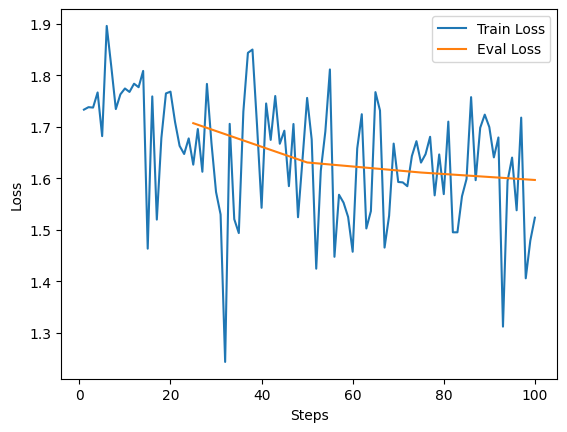

In [44]:
import matplotlib.pyplot as plt

# Initialize lists to hold training and evaluation losses and steps
train_losses = []
eval_losses = []
train_steps = []
eval_steps = []

# Populate the lists from the log history
for entry in trainer.state.log_history:
    if 'loss' in entry:
        train_losses.append(entry['loss'])
        train_steps.append(entry['step'])
    if 'eval_loss' in entry:
        eval_losses.append(entry['eval_loss'])
        eval_steps.append(entry['step'])

# Plot the losses
plt.plot(train_steps, train_losses, label='Train Loss')
plt.plot(eval_steps, eval_losses, label='Eval Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate after Training

In [45]:
# # Can set to true for faster inference
# model.config.use_cache = True

In [46]:
evaluation("base", tokenizer) #use this if training was done with an adapter preloaded. btw you'll always be running the model at the final checkpoint.

Generate config GenerationConfig {
  "bos_token_id": 32013,
  "eos_token_id": 32014,
  "pad_token_id": 32018
}



eval_model is on: cuda:0
input_ids are on: cuda:0
<｜begin▁of▁sentence｜>
### Instruction:
What planets are in our solar system?
### Response:
The planets in our solar system are Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, and Neptune.<｜end▁of▁sentence｜>


Generate config GenerationConfig {
  "bos_token_id": 32013,
  "eos_token_id": 32014,
  "pad_token_id": 32018
}






eval_model is on: cuda:0
input_ids are on: cuda:0
<｜begin▁of▁sentence｜>
### Instruction:
What are the first five numbers in the Fibonacci series?
### Response:
The Fibonacci series is a series of numbers in which each number is the sum of the two preceding numbers. The first two numbers in the series are 0 and 1, and each subsequent number is the sum of the two preceding numbers.

The first five numbers in the Fibonacci series are:

0, 1, 1, 2, 3

This series is named after the Italian mathematician Leonardo Fib


Generate config GenerationConfig {
  "bos_token_id": 32013,
  "eos_token_id": 32014,
  "pad_token_id": 32018
}






eval_model is on: cuda:0
input_ids are on: cuda:0
<｜begin▁of▁sentence｜>
### Instruction:
Generate a python code snippet to add two numbers.
### Response:
```python
# Add two numbers
num1 = 10
num2 = 20

# Add the two numbers
result = num1 + num2

# Print the result
print("The sum of", num1, "and", num2, "is", result)
```<｜end▁of▁sentence｜>





In [40]:
# checkpoint = save_dir + '/checkpoint-1'
# evaluation("fine-tuned", checkpoint)

In [41]:
# checkpoint = save_dir + '/checkpoint-15'
# evaluation("fine-tuned", checkpoint)

In [42]:
# checkpoint = save_dir + '/checkpoint-30'
# evaluation("fine-tuned", checkpoint)

In [43]:
# checkpoint = save_dir + '/checkpoint-45'
# evaluation("fine-tuned", checkpoint)

In [44]:
# checkpoint = save_dir + '/checkpoint-60'
# evaluation("fine-tuned", checkpoint)

# Merge Adapters and Save Model to Hub

In [45]:
### Only relevant if trying to load earlier adapters onto the base model.
# from peft import PeftModel

# adapter_to_push = save_dir + '/checkpoint-60'

# # load perf model with new adapters
# model_to_push = PeftModel.from_pretrained(
#     model,
#     adapter_to_push,
# )

In [47]:
# Define the save and push paths
adapter_model = f"Trelis/{model_name}-{fine_tune_tag}-adapters"
new_model = f"Trelis/{model_name}-{fine_tune_tag}" #adjust 'Trelis' to your HuggingFace organisation

In [48]:
# Save the model
model.save_pretrained(adapter_model, push_to_hub=True, use_auth_token=True)

In [49]:
model.push_to_hub(adapter_model, use_auth_token=True, max_shard_size="10GB", use_safetensors=True)

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:821: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Uploading the following files to Trelis/deepseek-coder-1.3b-base-chat-adapters: README.md,adapter_model.safetensors,adapter_config.json


adapter_model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Trelis/deepseek-coder-1.3b-base-chat-adapters/commit/91aec4793921268767930f985d32cb9094d615f2', commit_message='Upload model', commit_description='', oid='91aec4793921268767930f985d32cb9094d615f2', pr_url=None, pr_revision=None, pr_num=None)

In [51]:
# upload the trainable_params as well

from huggingface_hub import HfApi, create_repo, create_branch

create_repo(new_model, private=True)

create_branch(new_model, repo_type="model", branch="gguf")

# Initialize the HfApi class
api = HfApi()

# Specify the repository where you want to upload the files
repo_id = adapter_model

# Array of local file paths you want to upload
local_file_paths = [
    save_dir + "/trainable_params_final.bin",
]

# Loop through each file and upload it
for local_file_path in local_file_paths:
    # Extract the file name from the local file path
    file_name = local_file_path.split("/")[-1]

    # Specify the path where you want the file to be uploaded in the repository
    path_in_repo = file_name  # Using file_name directly, adjust as needed

    # Upload the file
    api.upload_file(
        path_or_fileobj=local_file_path,
        path_in_repo=path_in_repo,
        repo_id=repo_id,
        repo_type="model",  # Assuming it's a model; can be "dataset" or "space" as well
    )
    print(f"Uploaded {file_name} to {repo_id}")

trainable_params_final.bin:   0%|          | 0.00/147M [00:00<?, ?B/s]

Uploaded trainable_params_final.bin to Trelis/deepseek-coder-1.3b-base-chat-adapters


In [52]:
### Only needed if doing QLoRA - but you also need some more logic to be able to add in the non-LoRA trained parameters

# # from transformers import AutoModelForCausalLM, PretrainedConfig
# # import torch

# # reload the base model (you might need a pro subscription for this because you may need a high RAM environment since this is loading the full original model, not quantized)
# model = AutoModelForCausalLM.from_pretrained(
#     base_model,
#     quantization_config=bnb_config, # important to merge to the quantized version, otherwise there's small error
#     device_map='cpu',
#     trust_remote_code=True,
#     torch_dtype=torch.float16,
#     cache_dir=cache_dir)

In [53]:
model = model.merge_and_unload()

In [54]:
model.save_pretrained(new_model)

# Save the tokenizer to make sure the updated config is saved as well
tokenizer.save_pretrained(new_model)

Configuration saved in Trelis/deepseek-coder-1.3b-base-chat/config.json
Configuration saved in Trelis/deepseek-coder-1.3b-base-chat/generation_config.json
Model weights saved in Trelis/deepseek-coder-1.3b-base-chat/pytorch_model.bin
tokenizer config file saved in Trelis/deepseek-coder-1.3b-base-chat/tokenizer_config.json
Special tokens file saved in Trelis/deepseek-coder-1.3b-base-chat/special_tokens_map.json


('Trelis/deepseek-coder-1.3b-base-chat/tokenizer_config.json',
 'Trelis/deepseek-coder-1.3b-base-chat/special_tokens_map.json',
 'Trelis/deepseek-coder-1.3b-base-chat/tokenizer.json')

In [55]:
#Push the tokenizer

# # OR Reload from scratch if you don't want pad tokens to be in the tokenizer (which you don't if this makes the tokenizer size not be a multiple of 16)
# from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

## SET A CHAT TEMPLATE - RECOMMENDED!
# DeepSeek Coder Chat Template
tokenizer.chat_template = "{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{%- set ns = namespace(found=false) -%}{%- for message in messages -%}{%- if message['role'] == 'system' -%}{%- set ns.found = true -%}{%- endif -%}{%- endfor -%}{{bos_token}}{%- if not ns.found -%}{{'You are an AI assistant and you do your best to answer all questions and requests\n'}}{%- endif %}{%- for message in messages %}{%- if message['role'] == 'system' %}{{ message['content'] }}{%- else %}{%- if message['role'] == 'user' %}{{'Instruction:' + message['content'] + '\n'}}{%- else %}{{'\nOutput:' + message['content'] + '\n<|EOT|>\n'}}{%- endif %}{%- endif %}{%- endfor %}{% if add_generation_prompt %}{{'\nOutput:'}}{% endif %}"

tokenizer.push_to_hub(new_model, use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:821: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
tokenizer config file saved in /tmp/tmp2z_836su/tokenizer_config.json
Special tokens file saved in /tmp/tmp2z_836su/special_tokens_map.json
Uploading the following files to Trelis/deepseek-coder-1.3b-base-chat: tokenizer_config.json,special_tokens_map.json,tokenizer.json


CommitInfo(commit_url='https://huggingface.co/Trelis/deepseek-coder-1.3b-base-chat/commit/215cb6f0c0ab4d79e861130db05007ebb9bf0507', commit_message='Upload tokenizer', commit_description='', oid='215cb6f0c0ab4d79e861130db05007ebb9bf0507', pr_url=None, pr_revision=None, pr_num=None)

In [56]:
model.push_to_hub(new_model, use_auth_token=True, max_shard_size="10GB", use_safetensors=True)

Configuration saved in /tmp/tmpnjzlo3eh/config.json
Configuration saved in /tmp/tmpnjzlo3eh/generation_config.json
Model weights saved in /tmp/tmpnjzlo3eh/pytorch_model.bin
Uploading the following files to Trelis/deepseek-coder-1.3b-base-chat: config.json,generation_config.json,model.safetensors


model.safetensors:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Trelis/deepseek-coder-1.3b-base-chat/commit/6f0b2863be39c6a2932b2a90682f0934c89f5936', commit_message='Upload LlamaForCausalLM', commit_description='', oid='6f0b2863be39c6a2932b2a90682f0934c89f5936', pr_url=None, pr_revision=None, pr_num=None)

In [60]:
import os
import requests
from huggingface_hub import HfApi

def download_file_from_huggingface(model_id, filename, save_path):
    url = f"https://huggingface.co/{model_id}/resolve/main/{filename}"
    r = requests.get(url)
    if r.status_code != 200:
        print(f"Failed to download {filename}. HTTP Status Code: {r.status_code}")
        return False
    with open(os.path.join(save_path, filename), 'wb') as f:
        f.write(r.content)
    return True

def main():
    # Files to download and upload
    files_to_process = ["tokenizer.model", "README.md"]
    
    # Directory to save the downloaded files
    save_path = "./models"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # Initialize HfApi class
    api = HfApi()

    # Specify the repository where you want to upload the files
    repo_id = new_model  # Assuming new_model is in the format "username/repo"

    for filename in files_to_process:
        # Download the file
        success = download_file_from_huggingface(model_id, filename, save_path)
        if success:
            print(f"Successfully downloaded {filename}")
        else:
            print(f"Failed to download {filename}")
            continue  # Skip uploading if download failed

        # File path to upload
        local_file_path = os.path.join(save_path, filename)

        # Upload the file
        api.upload_file(
            path_or_fileobj=local_file_path,
            path_in_repo=filename,  # Using filename directly, adjust as needed
            repo_id=repo_id,
            repo_type="model",  # Assuming it's a model; can be "dataset" or "space" as well
        )
        print(f"Uploaded {filename} to {repo_id}")

if __name__ == "__main__":
    main()

Failed to download tokenizer.model. HTTP Status Code: 404
Failed to download tokenizer.model
Successfully downloaded README.md
Uploaded README.md to Trelis/deepseek-coder-1.3b-base-chat
